In [2]:
import os
import ast
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#### **Load Data**

In [3]:
def load_pickle(filename):
    return pd.read_pickle(filename)

In [6]:
# loading all data
# I'VE DELETE THE 'OLD' FOLDER (if you don't also this will retun an error)
grid = {}
for dirname in os.listdir('grid'):
    if os.path.isdir(f'grid/{dirname}'):
        grid[dirname] = {}
        for filename in os.listdir(f'grid/{dirname}'):
            if filename.endswith('.pkl'):
                key = filename.replace(f'{dirname}_', '').replace('.pkl', '')
                grid[dirname][key] = load_pickle(f'grid/{dirname}/{filename}')

# removing entropy
for key in grid.keys():
    grid[key].pop('entropy_sample', None)


# getting best param (for plotting purposes)
def read_txt(filename):
    with open(filename, 'r') as f:
        for current_line_number, line in enumerate(f, start=1):
            # since struc. does not change the params. we are interested
            # in are always in the same line, i.e. line 3
            if current_line_number == 3:  
                lst = line.split(': ')[-1].strip()
                
                return ast.literal_eval(lst)


for key, value in grid.items():
    # best_param has index
    # best_param_value has the value pertaining to that index
    grid[key]['best_param_value'] = read_txt(f'grid/{key}/{key}.txt')[grid[key]['best_param']]
    
print(grid.keys())
print(grid['fs_sigma_final'].keys())

dict_keys(['fitness_sharing_final', 'fs_sigma_final', 'mirror_prob_final', 'mutation_alg_prob_final', 'mutation_size_final', 'mut_prob_final', 'pop_size_final', 'selec_alg_final', 'tour_size_final', 'xo_alg_prob_final', 'xo_prob_final'])
dict_keys(['best_individuals_sample', 'best_param', 'compiled_history', 'variance_sample', 'best_param_value'])


In [29]:
# PoC
best_indivs = load_pickle('grid/selec_alg_final/selec_alg_final_best_individuals_sample.pkl')
best_params = load_pickle('grid/selec_alg_final/selec_alg_final_best_param.pkl')
best_variance = load_pickle('grid/selec_alg_final/selec_alg_final_variance_sample.pkl')
compiled_history = load_pickle('grid/selec_alg_final/selec_alg_final_compiled_history.pkl')

# i.e. len(best_indivs[i]) => configurations
# i.e. len(best_indivs[i][j]) => generations
# i.e. len(best_indivs[i][j][k]) => trials
# ... i.e. best_params = idx of best configuration? TODO check if True

# i.e. to make things clearer:
# best_indivs[0] => selecting config at index 0
# then it is a list of lists where we can imagine
# that we'll have generations as rows and trials as columns
#  --------> trials
# |
# |
# v
# generations
# ... therefore to get statistics like the mean of the best individuals
# across all trials for a specific generation we do it in axis=1
# best_indivs[0][0][0] -> the fitness of the best indiv of the 1st config, 1st generation, 1st trial
# best_indivs[0][1][0] -> the fitness of the best indiv of the 1st config, 2nd generation, 1st trial
# best_indivs[0][0][1] -> the fitness of the best indiv of the 1st config, 1st generation, 2nd trial

In [15]:
len(best_indivs)  # 2 configs

2

In [16]:
len(best_indivs[0])  # 2000 generations each

2000

In [17]:
len(best_indivs[0][0])  # 100 trials each

100

#### **Plotting Images**

In [7]:
# plot image

def plot_image(image, title='Image', size=None):
    if isinstance(image, str):
        image = Image.open(image)
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    else:
        raise ValueError('Image must be a string file path or a numpy array')
    
    if size:
        image = image.resize(size)
    
    plt.imshow(image, cmap='gray')
    plt.title(f'{title} ({image.size[0]}x{image.size[1]})')
    plt.show()

In [ ]:
# tests
# > original img
# > original img resized
# > example best image from run
# > example best image from run but resized to size of the original image

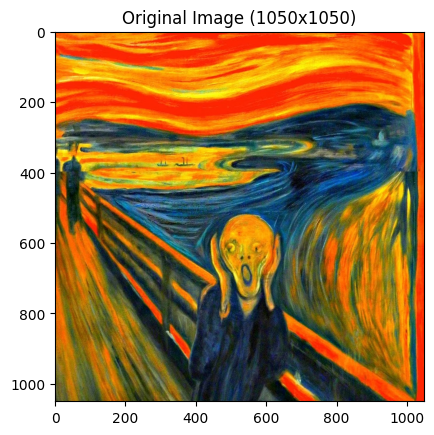

In [6]:
# original image
plot_image('scream.jpg', 'Original Image')

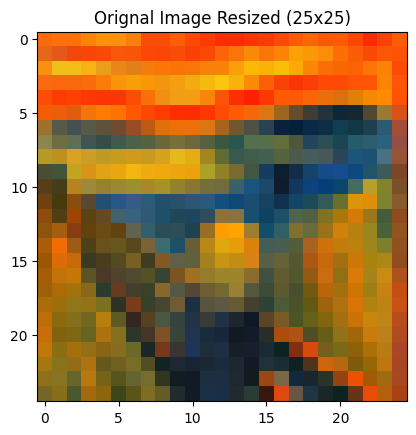

In [7]:
# originl image resized
plot_image('scream.jpg', 'Orignal Image Resized', size=(25, 25))

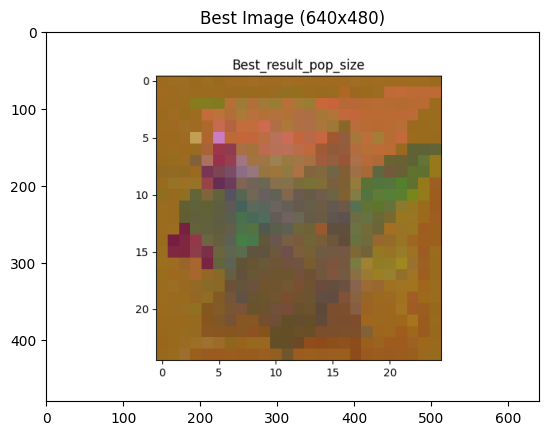

In [8]:
# example best image from run
plot_image('grid/pop_size_3/best_individual_pop_size.png', 'Best Image')

# ... ahah, need the real array

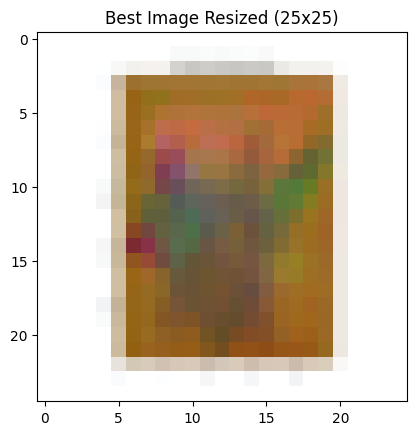

In [9]:
# example best image from run but resized to size of the original image
plot_image('grid/pop_size_3/best_individual_pop_size.png', 'Best Image Resized', size=(25, 25))

#### **For 1 Run**

In [6]:
def compare_trials(*trials):
    gens = range(len(trials[0]))  # assuming all trials have the same number of generations
    for i, trial in enumerate(trials):
        plt.plot(gens, trial, label=f'Trial {i+1}')
    plt.title('Fitness History')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.show()

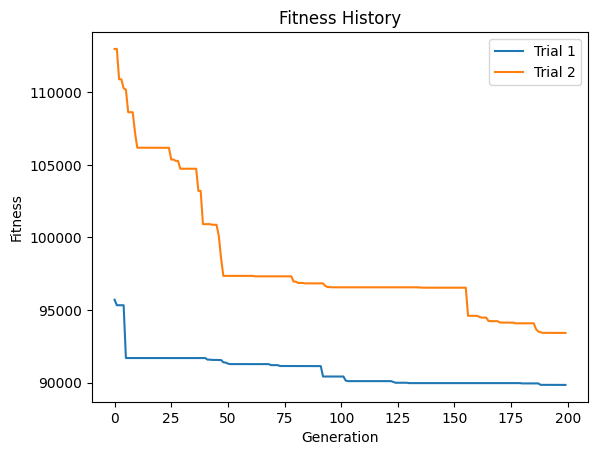

In [8]:
# tests
compare_trials([best_indivs[0][i][0] for i in range(200)], [best_indivs[0][i][1] for i in range(200)])

####  **For n Runs (ABF or MBF - avg. or median)**

In [13]:
def compare_configs(metric, parameter, *configs, title='Fitness History', error_bar_step=20, figsize=(6, 4), skip_gen=0):
    
    plt.figure(figsize=figsize)
        
    for i, config in enumerate(configs):
        if metric == 'mean':
            y = np.mean(config, axis=1)
            yerr = np.std(config, ddof=1, axis=1) / np.sqrt(len(configs[0]))  # len(config[0]) = n. trials
            
            if skip_gen > 0:
                y = y[skip_gen:]
                yerr = yerr[skip_gen:]
                    
        elif metric == 'median':
            y = np.median(config, axis=1)
            if skip_gen > 0:
                y = y[skip_gen:]
        else:
            raise ValueError('Invalid metric. Accepted are "mean" and "median".')
        
        x = range(len(y))
        
        # Plot the main line
        line, = plt.plot(x, y, label=f'Config. {i+1}', )
        color = line.get_color()
        
        # Adding error bars (mean only)
        if (error_bar_step > 0) & (metric != 'median'):        
            # Plot error bars at intervals
            error_x = x[::error_bar_step]
            error_y = y[::error_bar_step]
            error_yerr = yerr[::error_bar_step]
            plt.errorbar(error_x, error_y, yerr=error_yerr, fmt='o', capsize=5, color=color)

    plt.title(title)
    plt.xlabel('Generation')
    plt.ylabel(f'{metric.capitalize()} {parameter}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
grid.keys()

dict_keys(['fitness_sharing_final', 'fs_sigma_final', 'mirror_prob_final', 'mutation_alg_prob_final', 'mutation_size_final', 'mut_prob_final', 'pop_size_final', 'selec_alg_final', 'tour_size_final', 'xo_alg_prob_final', 'xo_prob_final'])

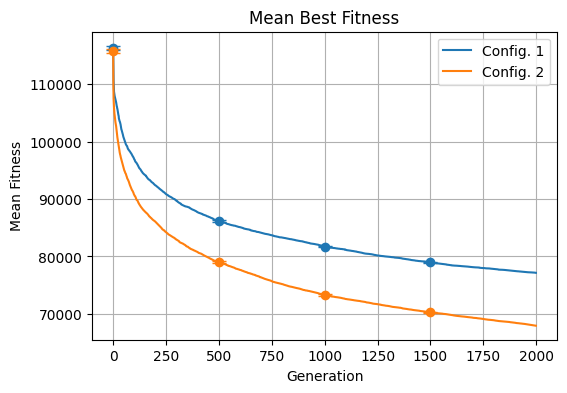

In [17]:
# tests:
# 1. 2 configs
# 2. one config
# 3. all configs

# compare_configs('median', 'Fitness', best_indivs[0], best_indivs[1], error_bar_step=0, title='Median Best Fitness')
# compare_configs('mean', 'Fitness', best_indivs[0], error_bar_step=500, title='Mean Best Fitness')
# compare_configs('mean', 'Fitness', *tuple(best_indivs), error_bar_step=500, title='Mean Best Fitness')

compare_configs('mean', 'Fitness',
                grid['pop_size_final']['best_individuals_sample'][grid['pop_size_final']['best_param']],
                grid['mut_prob_final']['best_individuals_sample'][grid['mut_prob_final']['best_param']],
                error_bar_step=500, title='Mean Best Fitness')

# ... everything working as intended

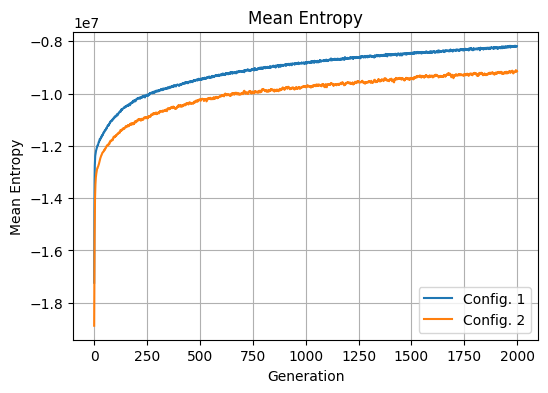

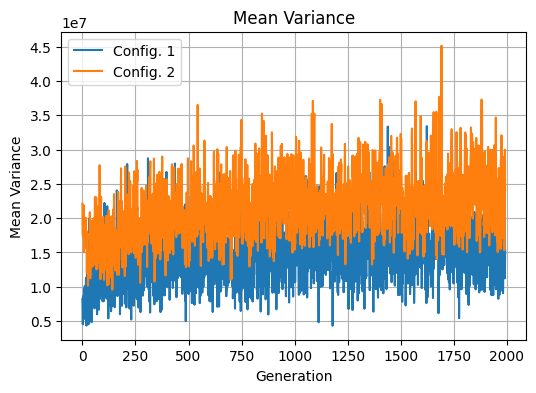

In [43]:
# other tests
compare_configs('mean', 'Variance', *tuple(best_variance), error_bar_step=0, title='Mean Variance', skip_gen=7)

#### **Comparison against computation effort**

In [35]:
best_indivs = load_pickle('grid/pop_size_final/pop_size_final_best_individual_list.pkl')

In [55]:
len(best_indivs[0])  # 2000 generations

2000

In [57]:
len(best_indivs[0][0])  # 100 trials

100

In [43]:
def get_pop_size(filename, config_idx):
    pop_sizes = read_txt(filename)
    return [pop_size for i, pop_size in enumerate(pop_sizes) if i in config_idx]
    
        
# test
print(f'Pop. size of config. 0: {get_pop_size('grid/pop_size_final/pop_size_final.txt', [0])}')
print(f'Pop. size of configs. 0, 1 and 2, respectively: {get_pop_size('grid/pop_size_final/pop_size_final.txt', [0, 1, 2])}')

Pop. size of config. 0: [10]
Pop. size of configs. 0, 1 and 2, respectively: [10, 50, 100]


In [52]:
def compare_effort(pop_sizes, configs, metric='mean', title='Computational Effort', figsize=(6, 4)):
    plt.figure(figsize=figsize)
    
    for i, config in enumerate(configs):
        x = pop_sizes[i] * np.arange(1, len(config)+1)
        y = np.mean(config, axis=1)
        plt.plot(x, y, label=f'Config. {i+1}: Pop. Size {pop_sizes[i]}')
    
    plt.title(title)
    plt.xlabel('# Fit. Eval.')
    plt.ylabel(f"{'Average' if metric=='mean' else 'Median'} Best Fitness")
    plt.legend()
    plt.show()

[   10    20    30 ... 19980 19990 20000]
[    50    100    150 ...  99900  99950 100000]
[   100    200    300 ... 199800 199900 200000]


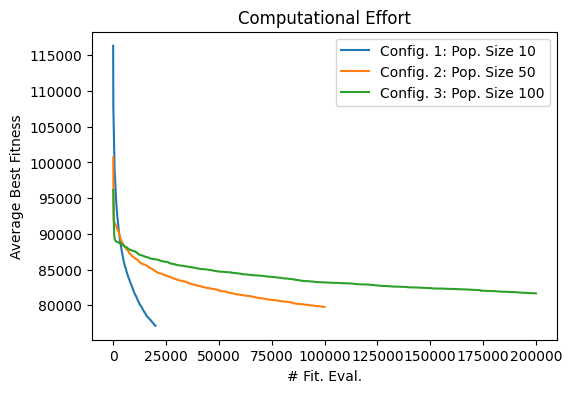

In [53]:
# tests
compare_effort(
    get_pop_size('grid/pop_size_final/pop_size_final.txt', [0, 1, 2]),
    [best_indivs[0], best_indivs[1], best_indivs[2]],
    metric='mean'
)